In [1]:
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os
import time
import tifffile
import imagecodecs
import scipy.optimize as sco

import math
import seaborn

import datetime

%pylab inline

#!conda install av -c conda-forge

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Setup Instructions: Create a folder inside the Data folder whose name is the date the data was taken in the
# format yyyy-mm-dd. Set data_date below to that date. Give the fueled and control videos the same name except
# the fueled ends in " FUELED.tif" while the control ends in " CONTROL.tif". Set movie_name below to the portion
# of the name that they share. Uncomment the proper scaling amount. Then this entire notebook is ready to run!

today = datetime.date.today().isoformat()
data_date = '2021-07-06'
home = os.getcwd()
movie_name = '75 mg per mL'
doing_fueled = False
doing_control = True

# scaling, measured in microns per pixel
scaling = 330 / 1247.96 # 20x1.0, measured 2021-06-17
#scaling = 220 / 1250.04 # 20x1.5, measured 2021-06-17
#scaling = 150 / 1127.54 # 40x1.0, measured 2021-06-16
#scaling = 100 / 1130.61 # 40x1.5, measured 2021-06-16
#scaling = 80 / 914.92 # 60x1.0, measured 2021-05-28
#scaling = 60 / 1031.07 # 60x1.5, measured 2021-05-28

data_folder = os.path.join(home, 'Data')
movie_data_folder = os.path.join(data_folder, data_date)
#fueled_file_name = os.path.join(movie_data_folder, movie_name + ' FUELED.tif')
#control_file_name = os.path.join(movie_data_folder, movie_name + ' CONTROL.tif')

In [6]:
# Declaring functions for channel separation.

@pims.pipeline
def red_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 1 * red + 0 * green + 0 * blue
    
@pims.pipeline
def green_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 0 * red + 1 * green + 0 * blue

In [7]:
# Creating folders for channel separation.

channel_separated_folder = os.path.join(home, 'Channel Separated Videos')
movie_channel_separated_folder = os.path.join(channel_separated_folder, today, movie_name)

if (not os.path.exists(data_folder)):
    os.mkdir(data_folder)
    print("Created " + data_folder)
if (not os.path.exists(movie_data_folder)):
    os.mkdir(movie_data_folder)
    print("Created " + movie_data_folder)
if (not os.path.exists(channel_separated_folder)):
    os.mkdir(channel_separated_folder)
    print("Created " + channel_separated_folder)
if (not os.path.exists(os.path.join(channel_separated_folder, today))):
    os.mkdir(os.path.join(channel_separated_folder, today))
    print("Created " + os.path.join(channel_separated_folder, today))
if (not os.path.exists(movie_channel_separated_folder)):
    os.mkdir(movie_channel_separated_folder)
    print("Created " + movie_channel_separated_folder)

Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Channel Separated Videos/2021-07-07/75 mg per mL


In [8]:
# Performing channel separation.

fueled_green = []
fueled_red = []
control_green = []
control_red = []

if doing_fueled:
    fueled_data = np.concatenate([pims.TiffStack(os.path.join(movie_data_folder, item))
                                 for item in sort(os.listdir(movie_data_folder)) if item.startswith('fueled')])
control_data = np.concatenate([pims.TiffStack(os.path.join(movie_data_folder, item))
                             for item in sort(os.listdir(movie_data_folder)) if item.startswith('control')])

# Fueled channel separation
if doing_fueled:
    for frame in fueled_data:
        fueled_green.append(green_separation(frame))
        fueled_red.append(red_separation(frame))
    with tifffile.TiffWriter(os.path.join(movie_channel_separated_folder, 'Fueled Green.tif')) as tif:
        for frame in fueled_green:
            tif.write(frame, contiguous=True)
    with tifffile.TiffWriter(os.path.join(movie_channel_separated_folder, 'Fueled Red.tif')) as tif:
        for frame in fueled_red:
            tif.write(frame, contiguous=True)

# Control channel separation
for frame in control_data:
    control_green.append(green_separation(frame))
    control_red.append(red_separation(frame))
with tifffile.TiffWriter(os.path.join(movie_channel_separated_folder, 'Control Green.tif')) as tif:
    for frame in control_green:
        tif.write(frame, contiguous=True)
with tifffile.TiffWriter(os.path.join(movie_channel_separated_folder, 'Control Red.tif')) as tif:
    for frame in control_red:
        tif.write(frame, contiguous=True)

if doing_fueled:
    del fueled_data
del control_data

In [9]:
if doing_fueled:
    fueled_green = list(pims.TiffStack(os.path.join(movie_channel_separated_folder, 'Fueled Green.tif')))
    fueled_red = list(pims.TiffStack(os.path.join(movie_channel_separated_folder, 'Fueled Red.tif')))
control_green = list(pims.TiffStack(os.path.join(movie_channel_separated_folder, 'Control Green.tif')))
control_red = list(pims.TiffStack(os.path.join(movie_channel_separated_folder, 'Control Red.tif')))

fps = 15.0
frametime = 1000/fps    # milliseconds

In [10]:
analysis_folder = os.path.join(home, 'Analysis')
movie_analysis_folder = os.path.join(analysis_folder, today, 'Data Taken ' + data_date + ', ' + movie_name)

if (not os.path.exists(analysis_folder)):
    os.mkdir(analysis_folder)
    print("Created " + analysis_folder)
if (not os.path.exists(os.path.join(analysis_folder, today))):
    os.mkdir(os.path.join(analysis_folder, today))
    print("Created " + os.path.join(analysis_folder, today))
if (not os.path.exists(movie_analysis_folder)):
    os.mkdir(movie_analysis_folder)
    print("Created " + movie_analysis_folder)

Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Analysis
Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Analysis/2021-07-07
Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Analysis/2021-07-07/Data Taken 2021-07-06, 75 mg per mL


In [11]:
if doing_fueled:
    plt.imshow(fueled_green[50])
    plt.title('A frame from Fueled Green')

In [12]:
if doing_fueled:
    plt.imshow(fueled_red[50])
    plt.title('A frame from Fueled Red')

Text(0.5, 1.0, 'A frame from Control Green')

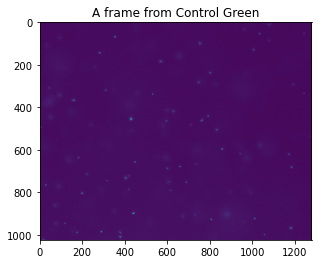

In [13]:
plt.imshow(control_green[50])
plt.title('A frame from Control Green')

Text(0.5, 1.0, 'A frame from Control Red')

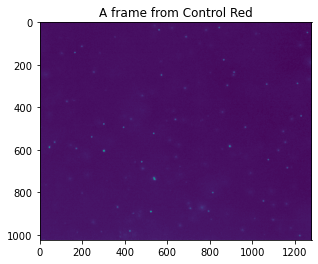

In [14]:
plt.imshow(control_red[50])
plt.title('A frame from Control Red')

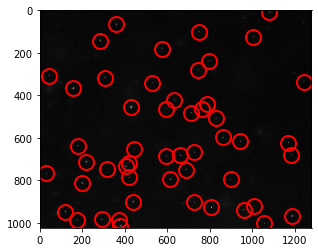

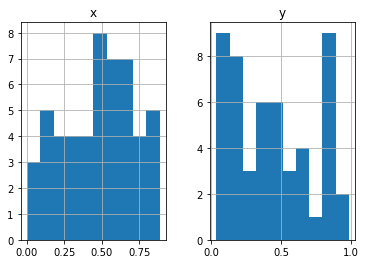

In [15]:
# Find bright spots in a frame of Fueled Green.
# featuresize must be odd.
# Read up on this in the trackpy literature.

i = 10 # Frame to search in
bright_background = False # Only true if looking for dark spots on a bright background
feature_size = 15 # Change this to find different size particles, can use ImageJ to get approximate feature size?
feature_mass = 500

f1 = tp.locate(control_green[i], diameter=feature_size, invert=bright_background, minmass=feature_mass)

plt.figure()  # make a new figure
tp.annotate(f1, control_green[i])

tp.subpx_bias(f1)  # for determining if particles bias a pixel

del f1

In [16]:
if doing_fueled:
    fueled_janus_coords = tp.batch(fueled_green, diameter=feature_size, invert=bright_background, minmass=feature_mass)
    tp.subpx_bias(fueled_janus_coords)

In [17]:
if doing_fueled:
    fueled_tracer_coords = tp.batch(fueled_red, diameter=feature_size, invert=bright_background, minmass=feature_mass)
    tp.subpx_bias(fueled_tracer_coords)

Frame 998: 88 features


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

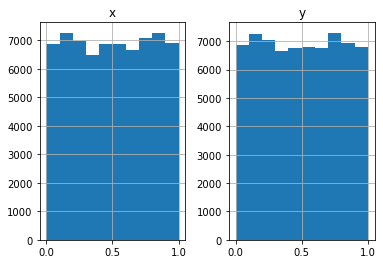

In [18]:
control_janus_coords = tp.batch(control_green, diameter=feature_size, invert=bright_background, minmass=feature_mass)
tp.subpx_bias(control_janus_coords)

Frame 998: 43 features


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

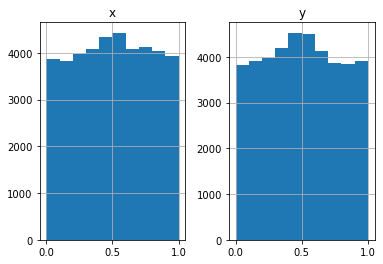

In [19]:
# Now that we have picked out an appropriate featuresize and settings, it's time to go through ALL the frames,
# finding the coordinates of the bright spots in each frame.
# batch already uses a loop to go through frames


control_tracer_coords = tp.batch(control_red, diameter=feature_size, invert=bright_background, minmass=feature_mass)
tp.subpx_bias(control_tracer_coords)

# Documentation: http://soft-matter.github.io/trackpy/generated/trackpy.batch.html

# This is an implementation of the Crocker-Grier centroid-finding algorithm.
#  Crocker, J.C., Grier, D.G. http://dx.doi.org/10.1006/jcis.1996.0217

In [20]:
# Note: These particle numbers count each frame individually, not the trajectories.
if doing_fueled:
    print('Fueled Janus')
    print('Number of Frames: ' + str(len(fueled_green)))
    print('Number of Particles: ' + str(len(fueled_janus_coords)))
    print()
    print('Fueled Tracer')
    print('Number of Frames: ' + str(len(fueled_red)))
    print('Number of Particles: ' + str(len(fueled_tracer_coords)))
    print()
print('Control Janus')
print('Number of Frames: ' + str(len(control_green)))
print('Number of Particles: ' + str(len(control_janus_coords)))
print()
print('Control Tracer')
print('Number of Frames: ' + str(len(control_red)))
print('Number of Particles: ' + str(len(control_tracer_coords)))

Control Janus
Number of Frames: 999
Number of Particles: 69217

Control Tracer
Number of Frames: 999
Number of Particles: 40688


In [21]:
# We have just built a list of coordinates called f_coords where we have seen particles. '
# Now we want to link these together from one frame to the next 
# so we can identify the trajectory for each particle.

# Documentation: http://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.link.html

# Fastest particle velocity observed in Viva's EPJST paper was about 15 microns/sec. Search
# range should be scalable based on that upper bound.
fastest = 15
memory = 5
search_range = int(round(15/(fps * scaling)))

if doing_fueled:
    fueled_janus_unfiltered = tp.link_df(f=fueled_janus_coords, search_range=search_range, memory=memory)
    fueled_tracer_unfiltered = tp.link_df(f=fueled_tracer_coords, search_range=search_range, memory=memory)
control_janus_unfiltered = tp.link_df(f=control_janus_coords, search_range=search_range, memory=memory)
control_tracer_unfiltered = tp.link_df(f=control_tracer_coords, search_range=search_range, memory=memory)

if doing_fueled:
    del fueled_janus_coords, fueled_tracer_coords
del control_janus_coords, control_tracer_coords

if doing_fueled:
    fueled_janus_unfiltered.to_pickle(movie_analysis_folder + 'fueled_janus_unfiltered.pkl')
    fueled_tracer_unfiltered.to_pickle(movie_analysis_folder + 'fueled_tracer_unfiltered.pkl')
control_janus_unfiltered.to_pickle(movie_analysis_folder + 'control_janus_unfiltered.pkl')
control_tracer_unfiltered.to_pickle(movie_analysis_folder + 'control_tracer_unfiltered.pkl')

# search_range gives the maximum distance features can move between frames. 
#              I think it's measured in pixels.
# memory gives the maximum number of frames during which a feature can vanish, 
#        then reappear nearby, and still be considered the same particle.
# This will run faster if the numba package is available.

Frame 998: 43 trajectories present.


In [22]:
print("The search range was {0}.".format(search_range))

The search range was 4.


Control Janus


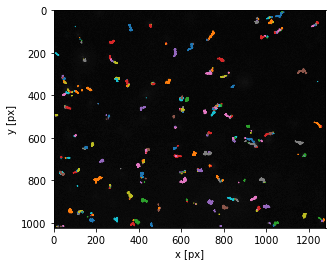

Control Tracer


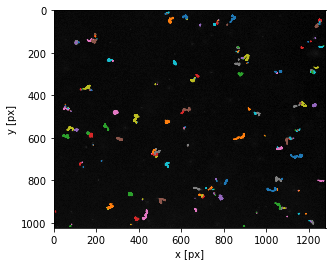

In [23]:
if doing_fueled:
    print('Fueled Janus')
    fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus_unfiltered,
                                   superimpose = fueled_green[int(len(fueled_green)/2)], label=False)

    print('Fueled Tracer')
    fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer_unfiltered,
                                   superimpose = fueled_red[int(len(fueled_red)/2)], label=False)

print('Control Janus')
control_janus_trajectory_plot = tp.plot_traj(control_janus_unfiltered,
                               superimpose = control_green[int(len(control_green)/2)], label=False)

print('Control Tracer')
control_tracer_trajectory_plot = tp.plot_traj(control_tracer_unfiltered,
                               superimpose = control_red[int(len(control_red)/2)], label=False)

In [24]:
# Only keep trajectories that last at least this many frames
filter_length = 10

if doing_fueled:
    fueled_janus = tp.filter_stubs(fueled_janus_unfiltered, filter_length)
    fueled_tracer = tp.filter_stubs(fueled_tracer_unfiltered, filter_length)
control_janus = tp.filter_stubs(control_janus_unfiltered, filter_length)
control_tracer = tp.filter_stubs(control_tracer_unfiltered, filter_length)

if doing_fueled:
    fueled_janus.to_pickle(movie_analysis_folder + 'fueled_janus.pkl')
    fueled_tracer.to_pickle(movie_analysis_folder + 'fueled_tracer.pkl')
control_janus.to_pickle(movie_analysis_folder + 'control_janus.pkl')
control_tracer.to_pickle(movie_analysis_folder + 'control_tracer.pkl')

# Compare the number of particles in the unfiltered and filtered data.
if doing_fueled:
    print('Fueled Janus')
    print('Before:', fueled_janus_unfiltered['particle'].nunique())
    print('After:', fueled_janus['particle'].nunique())
    metric4_fueled_janus = fueled_janus['particle'].nunique()
    print()
    print('Fueled Tracer')
    print('Before:', fueled_tracer_unfiltered['particle'].nunique())
    print('After:', fueled_tracer['particle'].nunique())
    metric4_fueled_tracer = fueled_tracer['particle'].nunique()
    print()
print('Control Janus')
print('Before:', control_janus_unfiltered['particle'].nunique())
print('After:', control_janus['particle'].nunique())
metric4_control_janus = control_janus['particle'].nunique()
print()
print('Control Tracer')
print('Before:', control_tracer_unfiltered['particle'].nunique())
print('After:', control_tracer['particle'].nunique())
metric4_control_tracer = control_tracer['particle'].nunique()

if doing_fueled:
    del fueled_janus_unfiltered, fueled_tracer_unfiltered
del control_janus_unfiltered, control_tracer_unfiltered


Control Janus
Before: 524
After: 312

Control Tracer
Before: 303
After: 172


Control Janus


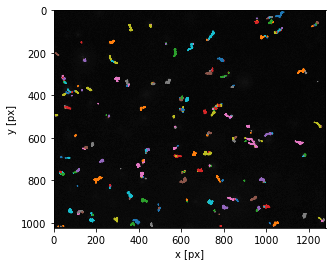

Control Tracer


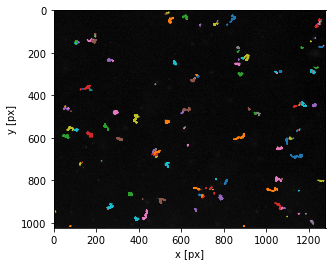

In [25]:
if doing_fueled:
    print('Fueled Janus')
    fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus,
                                   superimpose = fueled_green[int(len(fueled_green)/2)], label=False)

    print('Fueled Tracer')
    fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer,
                                   superimpose = fueled_red[int(len(fueled_red)/2)], label=False)

print('Control Janus')
control_janus_trajectory_plot = tp.plot_traj(control_janus,
                               superimpose = control_green[int(len(control_green)/2)], label=False)

print('Control Tracer')
control_tracer_trajectory_plot = tp.plot_traj(control_tracer,
                               superimpose = control_red[int(len(control_red)/2)], label=False)

Control Janus


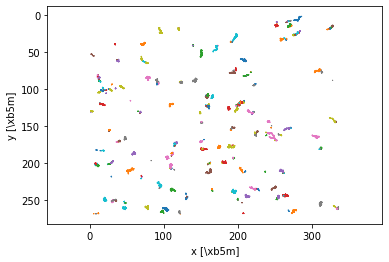

Control Tracer


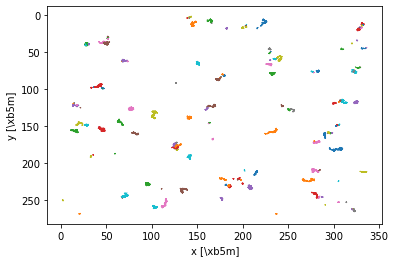

In [26]:
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass

if doing_fueled:
    print('Fueled Janus')
    fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus, mpp=scaling)

    print('Fueled Tracer')
    fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer, mpp=scaling)

print('Control Janus')
control_janus_trajectory_plot = tp.plot_traj(control_janus, mpp=scaling)

print('Control Tracer')
control_tracer_trajectory_plot = tp.plot_traj(control_tracer, mpp=scaling)

In [27]:
# Rotational drift subtraction starts here. First we need to define a bunch of functions.

## concatenate a new numerical column to a matrix
def put_z_position_in_matrix(mat2D, z=0):
    z_position = np.zeros(len(mat2D)) + z
    z_position = np.matrix(z_position)
    
    mat3D = np.concatenate((mat2D.T, z_position))
    mat3D = mat3D.T
    
    return mat3D

## Check to see if dataframe has z column; otherwise assume z=0.
def get_3D_matrix_from_dataframe(df, xlabel='x',ylabel='y',zlabel='z'):
    try:
        matrix = np.mat(df[[xlabel,ylabel,zlabel]])
    except KeyError:
        matrix = np.mat(df[[xlabel,ylabel]])
        matrix = put_z_position_in_matrix(matrix,0)
        
    return matrix

## The variable A_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## The variable B_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## This function currently assumes the particles tracked in the image frame 
## are all at the same z.

def matrices_from_dataframe(t1, framei, framef=None, z=0):
    
    # set default for final frame
    if framef == None:
        framef = framei+1
    
    # an inner merge will drop any rows for 
    # particles that are not in both frames 
    AB = pd.merge(t1[t1['frame'] == framei], 
                  t1[t1['frame'] == framef], 
                  how='inner', 
                  on='particle',
                  suffixes=('_i','_f'))

    # Pull out the coordinates and convert to matrices.
    # If z positions are not available, they are set to zero.
    A_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_i',ylabel='y_i',zlabel='z_i')
    B_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_f',ylabel='y_f',zlabel='z_f')
    
    assert len(A_3D) == len(B_3D)
    
    return A_3D, B_3D


## Given a matrix B which 
## has experienced rotation R and translation t, 
## undo that transformation.
def rotational_drift_subtraction(B, R, t):
    n = len(B)
    drift_subtracted = R.T * (B.T - np.tile(t,(1,n)))
    drift_subtracted = drift_subtracted.T
    
    return drift_subtracted

## This function is copied from http://nghiaho.com/uploads/code/rigid_transform_3D.py_
# Input: expects Nx3 matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    N = A.shape[0]; # total points

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.transpose(AA) * BB

    U, S, Vt = np.linalg.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if np.linalg.det(R) < 0:
       print("Reflection detected")
       Vt[2,:] *= -1
       R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T

    #print t

    return R, t

# Calculate the axis and angle of rotation for a given rotation matrix R

def axis_angle(R):
    h = R[2,1]
    f = R[1,2]
    c = R[0,2]
    g = R[2,0]
    d = R[1,0]
    b = R[0,1]
    
    # axis of rotation
    axis = [h-f, c-g, d-b]
    
    # angle of rotation, in radians
    angle = np.arccos((np.trace(R) - 1)/2)
    
    ## different way to calculate angle
    # axis_length = np.linalg.norm(axis)
    # angle = np.arcsin(axis_length/2) 
    
    return np.mat(axis), angle # in radians

def print_head(matrix, max_printable_length = 10):
    if len(matrix)>max_printable_length:
        print(matrix[0:max_printable_length])
        print("...")
    else:
        print(matrix)

In [28]:
# The main drift subtraction function. Set do_drift_subtraction to false if you don't care about calculating
# drift-subtracted trajectories and just want to plot the drift.

def drift_subtract(janus, tracer, do_drift_subtraction = True):
    # Before combining janus and tracer into particles, we must make them not have conflicting particle numbers.
    particles = tracer.copy()
    particles['particle'] += janus['particle'].max() + 1
    particles = particles.append(janus)
    
    if do_drift_subtraction:
        janus_nodrift = 0
        del janus_nodrift
        tracer_nodrift = 0
        del tracer_nodrift
    prev_frame = None
    R_list = []
    t_list = []
    x_drifts = []
    y_drifts = []
    z_drifts = []
    axis_list = []
    angle_list = []
    frame_list = []
    verbose = False

    labelx = 'x'
    labely = 'y'
    labelz = 'z'
    transformed_str = '_drift_subtracted'
    labelx2 = labelx + transformed_str
    labely2 = labely + transformed_str
    labelz2 = labelz + transformed_str
    labelnote = 'relative_to_frame'
    
    for current_frame in sort(particles.frame.unique()):
        if verbose:
            print("Frame ", current_frame)

        if prev_frame is None:
            relative_to = current_frame
            prev_frame = current_frame
            continue;  # skip first frame

        assert prev_frame is not None

        # A is a shorthand for the previous frame.
        # B is a shorthand for the current frame.

        # Get raw coordinates from current frame and previous frame
        A_3D, B_3D = matrices_from_dataframe(particles, prev_frame, current_frame)

        # Figure out the transformation that occured between frames
        ret_R, ret_t = rigid_transform_3D(A_3D, B_3D)

        # Save a copy of the transformation
        R_list.append(ret_R)
        t_list.append(ret_t)
        x_drifts.append(np.array(ret_t)[0][0])
        y_drifts.append(np.array(ret_t)[1][0])
        z_drifts.append(np.array(ret_t)[2][0])
        current_axis,current_angle = axis_angle(ret_R)
        axis_list.append(current_axis)
        angle_list.append(current_angle)
        frame_list.append(current_frame)

        if do_drift_subtraction:
            ## Do the rotational drift subtraction.
            ## I need to do this with all particles in current frame, 
            ## not just the ones that also appear in previous frame.

            B_dataframe_janus = janus[janus['frame'] == current_frame].copy()
            B_janus = get_3D_matrix_from_dataframe(B_dataframe_janus)
            
            B_dataframe_tracer = tracer[tracer['frame'] == current_frame].copy()
            B_tracer = get_3D_matrix_from_dataframe(B_dataframe_tracer)

            for R,t in zip(reversed(R_list),reversed(t_list)):
                if verbose:
                    print("undoing transformation")
                    print(R)
                B_janus = rotational_drift_subtraction(B_janus, R, t)
                B_tracer = rotational_drift_subtraction(B_tracer, R, t)
                # This is rather brute force, 
                # but I wanted to make sure I'm correct first.
                # The better thing to do is probably to calculate 
                # the total transformation before transforming the coordinates.

            ## Record the drift-subtracted coordinates
            # (i.e. Put the transformed data in the dataframe)

            x_sub_data_janus = np.array(B_janus[:,0]).T[0]
            y_sub_data_janus = np.array(B_janus[:,1]).T[0]
            z_sub_data_janus = np.array(B_janus[:,2]).T[0]
            
            x_sub_data_tracer = np.array(B_tracer[:,0]).T[0]
            y_sub_data_tracer = np.array(B_tracer[:,1]).T[0]
            z_sub_data_tracer = np.array(B_tracer[:,2]).T[0]

            B_dataframe_janus[labelx2]=x_sub_data_janus
            B_dataframe_janus[labely2]=y_sub_data_janus
            
            B_dataframe_tracer[labelx2]=x_sub_data_tracer
            B_dataframe_tracer[labely2]=y_sub_data_tracer

            # Assumes janus and tracer either both have z data or both don't
            if not np.array_equal(z_sub_data_janus, np.zeros_like(z_sub_data_janus)):
                ## Not tested with a z column
                B_dataframe_janus[labelz2]=z_sub_data_janus
                B_dataframe_tracer[labelz2]=z_sub_data_tracer
                num_new_cols = 4
            else:
                ## no z data
                num_new_cols = 3

            B_dataframe_janus[labelnote] = relative_to
            B_dataframe_tracer[labelnote] = relative_to

            try:
                janus_nodrift = pd.concat([janus_nodrift, B_dataframe_janus])
                tracer_nodrift = pd.concat([tracer_nodrift, B_dataframe_tracer])
            except NameError:
                # Initialize particles_nodrift
                janus_nodrift = B_dataframe_janus.copy()
                tracer_nodrift = B_dataframe_tracer.copy()

        prev_frame = current_frame

        # end loop

    ## Rename some columns in particles_nodrift
    if do_drift_subtraction:
        # Put the new columns up front
        janus_cols = janus_nodrift.columns.tolist()
        janus_cols = janus_cols[-num_new_cols:]+janus_cols[:-num_new_cols]
        janus_nodrift = janus_nodrift.reindex(columns=janus_cols)
        
        tracer_cols = tracer_nodrift.columns.tolist()
        tracer_cols = tracer_cols[-num_new_cols:]+tracer_cols[:-num_new_cols]
        tracer_nodrift = tracer_nodrift.reindex(columns=tracer_cols)

        ## Rename raw columns
        janus_nodrift = janus_nodrift.rename(index=str,
                       columns={labelx: labelx + "_raw", 
                                labely: labely + "_raw"})
        janus_nodrift = janus_nodrift.rename(index=str,
                       columns={labelx2: labelx,
                                labely2: labely})
        
        tracer_nodrift = tracer_nodrift.rename(index=str,
                       columns={labelx: labelx + "_raw", 
                                labely: labely + "_raw"})
        tracer_nodrift = tracer_nodrift.rename(index=str,
                       columns={labelx2: labelx,
                                labely2: labely})

        if num_new_cols == 4:
            ## Not tested with a z column
            janus_nodrift = janus_nodrift.rename(index=str, 
                           columns={labelz: labelz + "_raw"})
            janus_nodrift = janus_nodrift.rename(index=str,
                           columns={labelz2: labelz})
            
            tracer_nodrift = tracer_nodrift.rename(index=str, 
                           columns={labelz: labelz + "_raw"})
            tracer_nodrift = tracer_nodrift.rename(index=str,
                           columns={labelz2: labelz})
            
    # Subplots: https://matplotlib.org/stable/tutorials/introductory/pyplot.html
    plt.subplot(211)        
    plt.plot(frame_list,angle_list)
    plt.title(movie_name + '\nAngular drift\n')
    plt.xlabel('Frame')
    plt.ylabel('Angular drift [radians]')
    
    plt.subplot(212)
    plt.plot(frame_list,x_drifts, label="x")
    plt.plot(frame_list,y_drifts, label="y")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(movie_name + '\nTranslational drift\n')
    plt.xlabel('Frame')
    plt.ylabel('Translational drift [pixels]')
    
    return janus_nodrift, tracer_nodrift

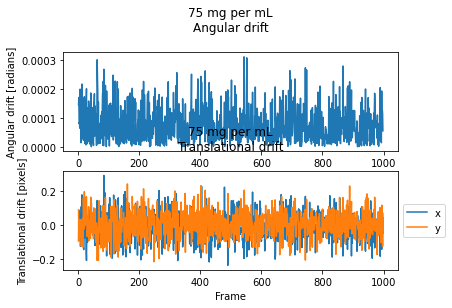

In [29]:
# Rotational drift subtraction continued. Now we are actually doing the subtraction, not just defining things.
if doing_fueled:
    fueled_janus_nodrift, fueled_tracer_nodrift = drift_subtract(fueled_janus, fueled_tracer)
control_janus_nodrift, control_tracer_nodrift = drift_subtract(control_janus, control_tracer)

if doing_fueled:
    fueled_janus_nodrift.to_pickle(movie_analysis_folder + 'fueled_janus_nodrift.pkl')
    fueled_tracer_nodrift.to_pickle(movie_analysis_folder + 'fueled_tracer_nodrift.pkl')
control_janus_nodrift.to_pickle(movie_analysis_folder + 'control_janus_nodrift.pkl')
control_tracer_nodrift.to_pickle(movie_analysis_folder + 'control_tracer_nodrift.pkl')

In [30]:
if doing_fueled:
    pylab.axis('equal')
    plt.title(movie_name + '\n Fueled Janus trajectories with drift subtraction\n')
    ax = tp.plot_traj(fueled_janus_nodrift, legend=False)

In [31]:
if doing_fueled:
    pylab.axis('equal')
    plt.title(movie_name + '\n Fueled Tracer trajectories with drift subtraction\n')
    ax = tp.plot_traj(fueled_tracer_nodrift, legend=False)

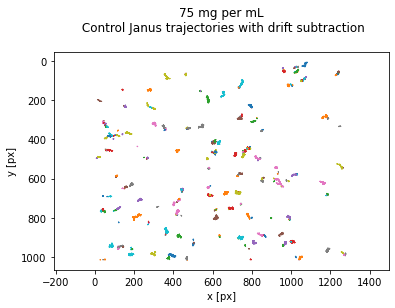

In [32]:
pylab.axis('equal')
plt.title(movie_name + '\n Control Janus trajectories with drift subtraction\n')
ax = tp.plot_traj(control_janus_nodrift, legend=False)

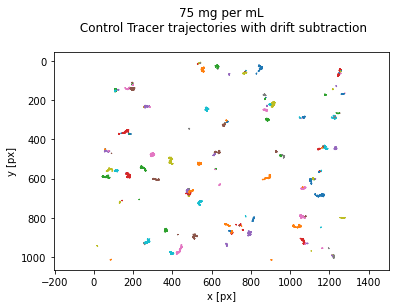

In [33]:
pylab.axis('equal')
plt.title(movie_name + '\n Control Tracer trajectories with drift subtraction\n')
ax = tp.plot_traj(control_tracer_nodrift, legend=False)

In [34]:
if doing_fueled:
    fueled_janus_imsd = tp.imsd(fueled_janus_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
    fueled_tracer_imsd = tp.imsd(fueled_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
control_janus_imsd = tp.imsd(control_janus_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
control_tracer_imsd = tp.imsd(control_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)

Text(0.5, 1.0, '75 mg per mL\nJanus iMSD, drift-subtracted\nRed = Fueled, Blue = Control')

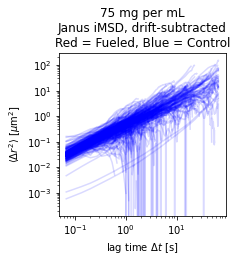

In [35]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_janus_imsd.index, fueled_janus_imsd, 'r-', alpha=0.15)
ax.plot(control_janus_imsd.index, control_janus_imsd, 'b-', alpha=0.15)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nJanus iMSD, drift-subtracted\nRed = Fueled, Blue = Control')

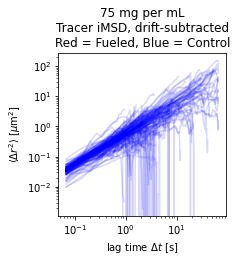

In [36]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_tracer_imsd.index, fueled_tracer_imsd, 'r-', alpha=0.15)
ax.plot(control_tracer_imsd.index, control_tracer_imsd, 'b-', alpha=0.15)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nTracer iMSD, drift-subtracted\nRed = Fueled, Blue = Control')

if doing_fueled:
    del fueled_janus_imsd, fueled_tracer_imsd
del control_janus_imsd, control_tracer_imsd

In [37]:
if doing_fueled:
    fueled_janus_imsd_drifty = tp.imsd(fueled_janus, mpp=scaling, fps=fps, max_lagtime=1000)
    fueled_tracer_imsd_drifty = tp.imsd(fueled_tracer, mpp=scaling, fps=fps, max_lagtime=1000)
control_janus_imsd_drifty = tp.imsd(control_janus, mpp=scaling, fps=fps, max_lagtime=1000)
control_tracer_imsd_drifty = tp.imsd(control_tracer, mpp=scaling, fps=fps, max_lagtime=1000)

Text(0.5, 1.0, '75 mg per mL\nJanus iMSD, not drift-subtracted\nRed = Fueled, Blue = Control')

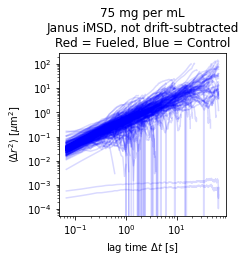

In [38]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_janus_imsd_drifty.index, fueled_janus_imsd_drifty, 'r-', alpha=0.15)
ax.plot(control_janus_imsd_drifty.index, control_janus_imsd_drifty, 'b-', alpha=0.15)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nJanus iMSD, not drift-subtracted\nRed = Fueled, Blue = Control')

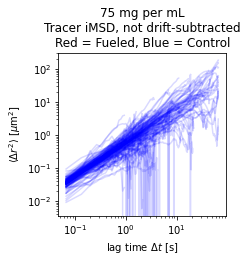

In [39]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_tracer_imsd_drifty.index, fueled_tracer_imsd_drifty, 'r-', alpha=0.15)
ax.plot(control_tracer_imsd_drifty.index, control_tracer_imsd_drifty, 'b-', alpha=0.15)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nTracer iMSD, not drift-subtracted\nRed = Fueled, Blue = Control')

if doing_fueled:
    del fueled_janus_imsd_drifty, fueled_tracer_imsd_drifty
del control_janus_imsd_drifty, control_tracer_imsd_drifty

In [40]:
if doing_fueled:
    fueled_janus_emsd = tp.emsd(fueled_janus_nodrift, mpp=scaling, fps=fps).replace(0, NaN).dropna()
    fueled_tracer_emsd = tp.emsd(fueled_tracer_nodrift, mpp=scaling, fps=fps).replace(0, NaN).dropna()
control_janus_emsd = tp.emsd(control_janus_nodrift, mpp=scaling, fps=fps).replace(0, NaN).dropna()
control_tracer_emsd = tp.emsd(control_tracer_nodrift, mpp=scaling, fps=fps).replace(0, NaN).dropna()

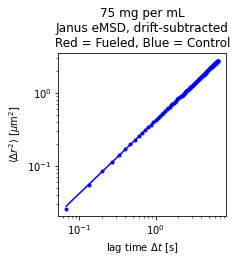

In [41]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_janus_fit = tp.utils.fit_powerlaw(fueled_janus_emsd, plot = False)
    fueled_janus_fit_x = [1/fps, (1/fps) * len(fueled_janus_emsd)]
    fueled_janus_fit_y = [fueled_janus_fit.A[0] * np.power(fueled_janus_fit_x[0], fueled_janus_fit.n[0]),
                         fueled_janus_fit.A[0] * np.power(fueled_janus_fit_x[1], fueled_janus_fit.n[0])]

control_janus_fit = tp.utils.fit_powerlaw(control_janus_emsd, plot = False)
control_janus_fit_x = [1/fps, (1/fps) * len(control_janus_emsd)]
control_janus_fit_y = [control_janus_fit.A[0] * np.power(control_janus_fit_x[0], control_janus_fit.n[0]),
                     control_janus_fit.A[0] * np.power(control_janus_fit_x[1], control_janus_fit.n[0])]

if doing_fueled:
    fueled_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)
    plt.plot(fueled_janus_fit_x, fueled_janus_fit_y, 'r')

control_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1)
plt.plot(control_janus_fit_x, control_janus_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + '\nJanus eMSD, drift-subtracted\nRed = Fueled, Blue = Control')

plt.savefig(os.path.join(movie_analysis_folder, 'janus_eMSDs.png'))

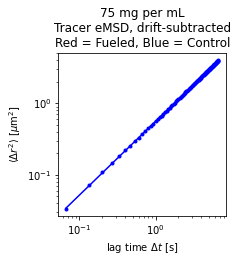

In [42]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_tracer_fit = tp.utils.fit_powerlaw(fueled_tracer_emsd, plot = False)
    fueled_tracer_fit_x = [1/fps, (1/fps) * len(fueled_tracer_emsd)]
    fueled_tracer_fit_y = [fueled_tracer_fit.A[0] * np.power(fueled_tracer_fit_x[0], fueled_tracer_fit.n[0]),
                         fueled_tracer_fit.A[0] * np.power(fueled_tracer_fit_x[1], fueled_tracer_fit.n[0])]

control_tracer_fit = tp.utils.fit_powerlaw(control_tracer_emsd, plot = False)
control_tracer_fit_x = [1/fps, (1/fps) * len(control_tracer_emsd)]
control_tracer_fit_y = [control_tracer_fit.A[0] * np.power(control_tracer_fit_x[0], control_tracer_fit.n[0]),
                     control_tracer_fit.A[0] * np.power(control_tracer_fit_x[1], control_tracer_fit.n[0])]

if doing_fueled:
    fueled_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)
    plt.plot(fueled_tracer_fit_x, fueled_tracer_fit_y, 'r')

control_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1)
plt.plot(control_tracer_fit_x, control_tracer_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + '\nTracer eMSD, drift-subtracted\nRed = Fueled, Blue = Control')

plt.savefig(os.path.join(movie_analysis_folder, 'tracer_eMSDs.png'))

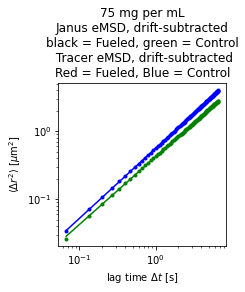

In [43]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'k.',  grid=False, ax=ax1, label="fueled Janus")
    plt.plot(fueled_janus_fit_x, fueled_janus_fit_y, 'k')

control_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'g.',  grid=False, ax=ax1, label="control Janus")
plt.plot(control_janus_fit_x, control_janus_fit_y, 'g')

if doing_fueled:
    fueled_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1, label="fueled Tracer")
    plt.plot(fueled_tracer_fit_x, fueled_tracer_fit_y, 'r')

control_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1, label="control Tracer")
plt.plot(control_tracer_fit_x, control_tracer_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + 
          '\nJanus eMSD, drift-subtracted\nblack = Fueled, green = Control'
          + '\n Tracer eMSD, drift-subtracted\nRed = Fueled, Blue = Control')


plt.savefig(os.path.join(movie_analysis_folder, 'janus+tracer_eMSDs.pdf'))



In [44]:
if doing_fueled:
    print('Fueled Janus: n =', fueled_janus_fit.values[0,0], 'A =' , fueled_janus_fit.values[0,1])
    print('Fueled Tracers: n =', fueled_tracer_fit.values[0,0], 'A =' , fueled_tracer_fit.values[0,1])
print('Control Janus: n =', control_janus_fit.values[0,0], 'A =' , control_janus_fit.values[0,1])
print('Control Tracers: n =', control_tracer_fit.values[0,0], 'A =' , control_tracer_fit.values[0,1])

if doing_fueled:
    fueled_janus_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
    fueled_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
control_janus_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
control_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))

if doing_fueled:
    del fueled_janus_emsd, fueled_tracer_emsd
del control_janus_emsd, control_tracer_emsd

Control Janus: n = 0.9972126813077573 A = 0.4207131003492201
Control Tracers: n = 1.0305342129989592 A = 0.559214160341101


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, '$\\Delta$ x ($\\mu$m)')

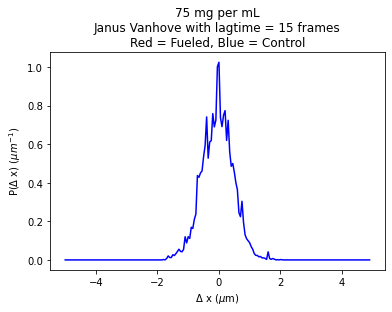

In [45]:
# Based on my previous code, I suspect the commands will be something like:

vanhove_lagtime = 15 # Measured in frames
vanhove_max_x = 5
binwidth = 0.05

## reorder tracks by frame number
if doing_fueled:
    tracksbyframe_fueled_janus = fueled_janus_nodrift.set_index(['frame','particle'])['x'].unstack()
tracksbyframe_control_janus = control_janus_nodrift.set_index(['frame','particle'])['x'].unstack()
binsequence=arange(-vanhove_max_x,vanhove_max_x,binwidth)
## This makes a histogram of how far the particles traveled
#    You can choose the lagtime
if doing_fueled:
    trackshist_fueled_janus_lg6 = tp.motion.vanhove(tracksbyframe_fueled_janus, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)
trackshist_control_janus_lg6 = tp.motion.vanhove(tracksbyframe_control_janus, lagtime = vanhove_lagtime, mpp =
scaling,bins = binsequence, ensemble = True)

if doing_fueled:
    del tracksbyframe_fueled_janus
del binsequence, tracksbyframe_control_janus

## Viva's histogram normalization function
def manualnorm(histdata):
     return (1/(histdata.sum()*binwidth))*histdata
if doing_fueled:
    trackshist_fueled_janus_lg6_norm = manualnorm(trackshist_fueled_janus_lg6)
trackshist_control_janus_lg6_norm = manualnorm(trackshist_control_janus_lg6)
if doing_fueled:
    trackshist_fueled_janus_lg6_norm.plot(color = 'red')
trackshist_control_janus_lg6_norm.plot(color = 'blue')
plt.title(movie_name + '\nJanus Vanhove with lagtime = ' + str(vanhove_lagtime)
          + ' frames\nRed = Fueled, Blue = Control')
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu$m)')

In [46]:
def gaussian(x,a,b,c):
    return a*(exp(-((x-b)**2)/(2*(c**2))))

# Curve fit a Gaussian to the Vanhoves
if doing_fueled:
    fueled_janus_params, fueled_janus_covm = sco.curve_fit(gaussian, trackshist_fueled_janus_lg6_norm.index,
                                                          trackshist_fueled_janus_lg6_norm.values)
    fueled_janus_yfit = gaussian(trackshist_fueled_janus_lg6_norm.index, fueled_janus_params[0],
                                 fueled_janus_params[1], fueled_janus_params[2])

    trackshist_fueled_janus_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_fueled_janus_lg6_norm.index, fueled_janus_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nFueled Janus Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')

    # If you want to change the x and y limits:
    # ylim(ymin=0.00003, ymax=10)
    xlim(-vanhove_max_x,vanhove_max_x)

Text(0.5, 0, '$\\Delta$ x (micron)')

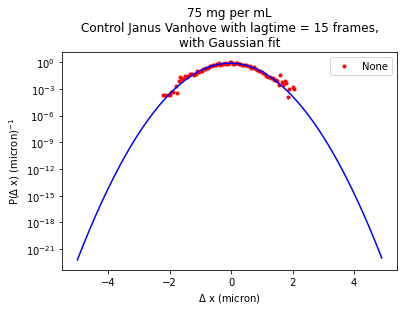

In [47]:
# Curve fit a Gaussian to the Vanhoves
control_janus_params, control_janus_covm = sco.curve_fit(gaussian, trackshist_control_janus_lg6_norm.index,
                                                            trackshist_control_janus_lg6_norm.values)
control_janus_yfit = gaussian(trackshist_control_janus_lg6_norm.index, control_janus_params[0],
                               control_janus_params[1], control_janus_params[2])

trackshist_control_janus_lg6_norm.plot(style = 'r.')
plt.plot(trackshist_control_janus_lg6_norm.index, control_janus_yfit, color = 'b')

plt.yscale('log')
plt.title(movie_name + '\nControl Janus Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
plt.legend()
plt.ylabel('P($\Delta$ x) (micron)$^{-1}$')
plt.xlabel('$\Delta$ x (micron)')

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, '$\\Delta$ x ($\\mu m$)')

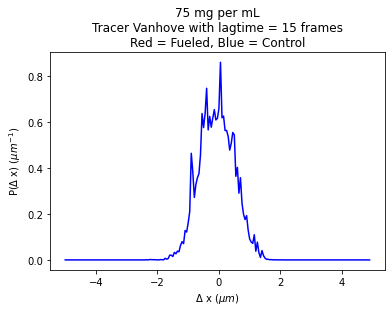

In [48]:
# Based on my previous code, I suspect the commands will be something like:

## reorder tracks by frame number
if doing_fueled:
    tracksbyframe_fueled_tracer = fueled_tracer_nodrift.set_index(['frame','particle'])['x'].unstack()
tracksbyframe_control_tracer = control_tracer_nodrift.set_index(['frame','particle'])['x'].unstack()
binsequence=arange(-vanhove_max_x,vanhove_max_x,binwidth)
## This makes a histogram of how far the particles traveled
#    You can choose the lagtime
if doing_fueled:
    trackshist_fueled_tracer_lg6 = tp.motion.vanhove(tracksbyframe_fueled_tracer, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)
trackshist_control_tracer_lg6 = tp.motion.vanhove(tracksbyframe_control_tracer, lagtime = vanhove_lagtime, mpp =
scaling,bins = binsequence, ensemble = True)

if doing_fueled:
    del tracksbyframe_fueled_tracer
del binsequence, tracksbyframe_control_tracer

if doing_fueled:
    trackshist_fueled_tracer_lg6_norm = manualnorm(trackshist_fueled_tracer_lg6)
trackshist_control_tracer_lg6_norm = manualnorm(trackshist_control_tracer_lg6)
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm.plot(color = 'red')
trackshist_control_tracer_lg6_norm.plot(color = 'blue')
plt.title(movie_name + '\nTracer Vanhove with lagtime = ' + str(vanhove_lagtime)
          + ' frames\nRed = Fueled, Blue = Control')
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)')

In [49]:
# Curve fit a Gaussian to the Vanhoves
if doing_fueled:
    fueled_tracer_params, fueled_tracer_covm = sco.curve_fit(gaussian, trackshist_fueled_tracer_lg6_norm.index,
                                                          trackshist_fueled_tracer_lg6_norm.values)
    fueled_tracer_yfit = gaussian(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_params[0],
                                 fueled_tracer_params[1], fueled_tracer_params[2])

    trackshist_fueled_tracer_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nFueled Tracer Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')

Text(0.5, 0, '$\\Delta$ x ($\\mu m$)')

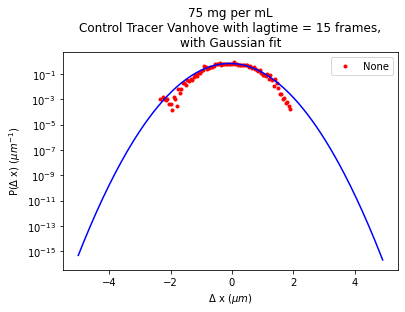

In [50]:
# Curve fit a Gaussian to the Vanhoves
control_tracer_params, control_tracer_covm = sco.curve_fit(gaussian, trackshist_control_tracer_lg6_norm.index,
                                                      trackshist_control_tracer_lg6_norm.values)
control_tracer_yfit = gaussian(trackshist_control_tracer_lg6_norm.index, control_tracer_params[0],
                             control_tracer_params[1], control_tracer_params[2])

trackshist_control_tracer_lg6_norm.plot(style = 'r.')
plt.plot(trackshist_control_tracer_lg6_norm.index, control_tracer_yfit, color = 'b')

plt.yscale('log')
plt.title(movie_name + '\nControl Tracer Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
plt.legend()
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)')

(1e-06, 13.231426414044176)

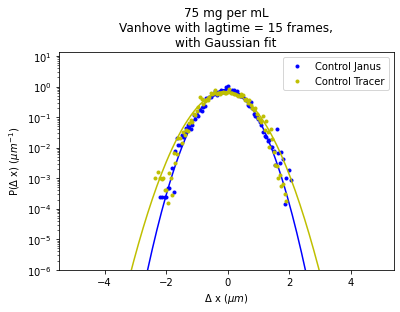

In [51]:
if doing_fueled:
    trackshist_fueled_janus_lg6_norm.plot(style = 'r.', label = 'Fueled Janus')
    plt.plot(trackshist_fueled_janus_lg6_norm.index, fueled_janus_yfit, color = 'r')
trackshist_control_janus_lg6_norm.plot(style = 'b.', label = 'Control Janus')
plt.plot(trackshist_control_janus_lg6_norm.index, control_janus_yfit, color = 'b')
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm.plot(style = 'g.', label = 'Fueled Tracer')
    plt.plot(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_yfit, color = 'g')
trackshist_control_tracer_lg6_norm.plot(style = 'y.', label = 'Control Tracer')
plt.plot(trackshist_control_tracer_lg6_norm.index, control_tracer_yfit, color = 'y')

plt.yscale('log')
plt.title(movie_name + '\nVanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
plt.legend()
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)')
plt.ylim(ymin=1e-6)

In [52]:
print('EXCESS KURTOSIS')
if doing_fueled:
    print('Fueled Janus: ' + str(trackshist_fueled_janus_lg6_norm.kurtosis()))
    metric3_fueled_janus = str(trackshist_fueled_janus_lg6_norm.kurtosis())
    print('Fueled Tracer: ' + str(trackshist_fueled_tracer_lg6_norm.kurtosis()))
    metric3_fueled_tracer = str(trackshist_fueled_tracer_lg6_norm.kurtosis())
print('Control Janus: ' + str(trackshist_control_janus_lg6_norm.kurtosis()))
metric3_control_janus = str(trackshist_control_janus_lg6_norm.kurtosis())
print('Control Tracer: ' + str(trackshist_control_tracer_lg6_norm.kurtosis()))
metric3_control_tracer = str(trackshist_control_tracer_lg6_norm.kurtosis())

EXCESS KURTOSIS
Control Janus: 4.51516065946997
Control Tracer: 2.4809302393320127


In [55]:
# Assumes all videos have the same pixel length and width
(y_size,x_size) = control_green[0].shape

new_movie_fps = 15   # doesn't have to be the same as fps
trajectory_folder = os.path.join(home, 'Trajectory')
movie_trajectory_folder = os.path.join(trajectory_folder, today, movie_name)

if (not os.path.exists(trajectory_folder)):
    os.mkdir(trajectory_folder)
    print("Created " + trajectory_folder)
if (not os.path.exists(os.path.join(trajectory_folder, today))):
    os.mkdir(os.path.join(trajectory_folder, today))
    print("Created " + os.path.join(trajectory_folder, today))
if (not os.path.exists(movie_trajectory_folder)):
    os.mkdir(movie_trajectory_folder)
    print("Created " + movie_trajectory_folder)

Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Trajectory
Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Trajectory/2021-07-07
Created /Users/mjankows/Desktop/2021-07-07 peg 8000 75 mg:ml/Trajectory/2021-07-07/75 mg per mL


In [56]:
frametime_sec = frametime/1000.0

In [57]:
scalebar_length_um = 15
vertical_separation = 300
horizontal_separation = 50
text_bar_separation = 25
fontsz=12
approx_length_of_text_px = 135
scalebar_height = 20
scalebar_bottom = x_size -vertical_separation
scalebar_top = scalebar_bottom - scalebar_height
scalebar_length_px = scalebar_length_um/scaling
scalebar_left_px = 0 + horizontal_separation              #scalebar_right_px - scalebar_length_px
scalebar_right_px = scalebar_left_px + scalebar_length_px #y_size-horizontal_separation
scalebar_left_percent = scalebar_left_px/(x_size*1.0)
#scalebar_length_percent = scalebar_length_px/(x_size*1.0)
#xmax = scalebar_length_percent + scalebar_left_percent
xmax = scalebar_right_px /(x_size*1.0)
scalebar_greyscale = '0.1'
center_of_bar = (scalebar_left_px + scalebar_right_px)/2.0

72.0

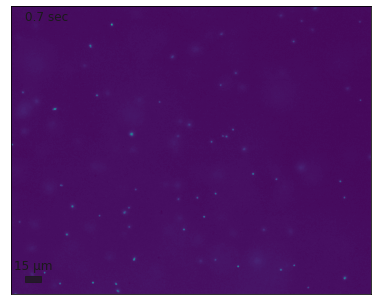

In [59]:
i = 10

fig = plt.figure(figsize=[5,5],frameon=False)
ax = fig.add_axes([0,0,1,1])
ax.imshow(control_green[i])

axhspan(scalebar_top, 
            scalebar_top + scalebar_height, 
            xmin=scalebar_left_percent, 
            xmax=xmax,
            color=scalebar_greyscale, 
            alpha=0.75)
text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
         str(scalebar_length_um) + u' \u03bcm',
         fontsize=fontsz,
         color=scalebar_greyscale)
text(horizontal_separation, horizontal_separation, "{:.1f}".format(i*frametime_sec) + ' sec',
     fontsize=fontsz,
     color=scalebar_greyscale)


ylim(y_size,0)
xlim(0,x_size)
xticks([],'')
yticks([],'')

fig.dpi

In [60]:
if doing_fueled:
    print("fueled janus n: {0}".format(fueled_janus_fit.values[0,0]))
    print("fueled janus A: {0}".format(fueled_janus_fit.values[0,1]))
    print("fueled janus EXCESS KURTOSIS: {0}".format(str(metric3_fueled_janus)))
    print("fueled janus NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_fueled_janus))

print("control janus n: {0}".format(control_janus_fit.values[0,0]))
print("control janus A: {0}".format(control_janus_fit.values[0,1]))
print("control janus EXCESS KURTOSIS: {0}".format(str(metric3_control_janus)))
print("control janus NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_control_janus))

if doing_fueled:
    print("fueled tracer n: {0}".format(fueled_tracer_fit.values[0,0]))
    print("fueled tracer A: {0}".format(fueled_tracer_fit.values[0,1]))
    print("fueled tracer EXCESS KURTOSIS: {0}".format(str(metric3_fueled_tracer)))
    print("fueled tracer NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_fueled_tracer))

print("control tracer n: {0}".format(control_tracer_fit.values[0,0]))
print("control tracer A: {0}".format(control_tracer_fit.values[0,1]))
print("control tracer EXCESS KURTOSIS: {0}".format(str(metric3_control_tracer)))
print("control tracer NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_control_tracer))

control janus n: 0.9972126813077573
control janus A: 0.4207131003492201
control janus EXCESS KURTOSIS: 4.51516065946997
control janus NUMBER OF PARTICLES AFTER FILTERING: 312
control tracer n: 1.0305342129989592
control tracer A: 0.559214160341101
control tracer EXCESS KURTOSIS: 2.4809302393320127
control tracer NUMBER OF PARTICLES AFTER FILTERING: 172


In [61]:
def make_movie_images(particles, frames, name):
    tracks_to_show = particles['particle'].astype(int).unique()

    # Thanks to Becca Perry for helping me with this code.
    for i in range(len(frames)): 
        #print(i)
        fig = plt.figure(figsize=[5,5],frameon=False)
        ax = fig.add_axes([0,0,1,1])

        implot = ax.imshow(frames[i])

        traj_hist =  particles[particles.frame <=i]

        for this_particle in tracks_to_show:
            this_traj_hist = traj_hist[traj_hist.particle == this_particle]
            this_xcoords_hist = this_traj_hist['x']
            this_ycoords_hist = this_traj_hist['y']
            plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

        thisframefavcoords = particles[particles.frame ==i]
        xcoords = thisframefavcoords['x']
        ycoords = thisframefavcoords['y']
        plot(xcoords.values,ycoords.values, 'r.', alpha=0.2)

        # scalebar
        axhspan(scalebar_top, 
                scalebar_top + scalebar_height, 
                xmin=scalebar_left_percent, 
                xmax=xmax,
                color=scalebar_greyscale, 
                alpha=0.75)

        # scalebar label
        text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
             str(scalebar_length_um) + u' \u03bcm',
             fontsize=fontsz,
             color=scalebar_greyscale)

        # time stamp
        text(horizontal_separation, horizontal_separation, "{:.1f}".format(i*frametime_sec) + ' sec',
             fontsize=fontsz,
             color=scalebar_greyscale)

        ylim(y_size,0)
        xlim(0,x_size)
        xticks([],'')
        yticks([],'')

        savefig(os.path.join(movie_trajectory_folder, name + '_' + str(i).zfill(4) +'.tif'),
               dpi = fig.dpi)

        if i < len(frames)-1:
            close()

In [62]:
if doing_fueled:
    make_movie_images(fueled_janus, fueled_green, 'fueled_janus')
    del fueled_janus, fueled_green

In [63]:
if doing_fueled:
    make_movie_images(fueled_tracer, fueled_red, 'fueled_tracer')
    del fueled_tracer, fueled_red

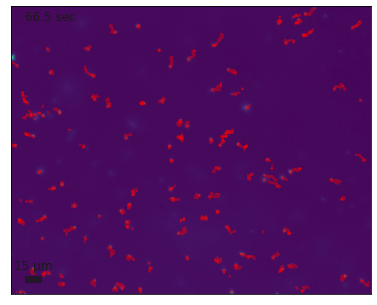

In [64]:
make_movie_images(control_janus, control_green, 'control_janus')
del control_janus, control_green

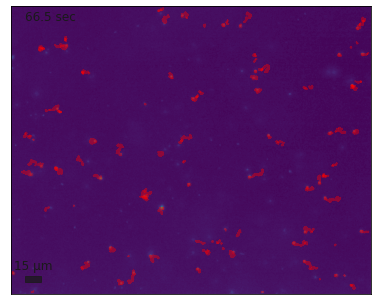

In [65]:
make_movie_images(control_tracer, control_red, 'control_tracer')
del control_tracer, control_red

In [68]:
import cv2

os.chdir(movie_trajectory_folder)

def make_movie_video(name):
    images = [img for img in sort(os.listdir(movie_trajectory_folder)) if (img.startswith(name) and img.endswith('.tif'))]
    frame = cv2.imread(os.path.join(movie_trajectory_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(name + ".avi", 0, 15, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(movie_trajectory_folder, image)))
        os.remove(os.path.join(movie_trajectory_folder, image))

    cv2.destroyAllWindows()
    video.release()

if doing_fueled:
    make_movie_video('fueled_janus')
    make_movie_video('fueled_tracer')
make_movie_video('control_janus')
make_movie_video('control_tracer')

os.chdir(home)